[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Andrei-Aksionov/xai-vit/blob/main/notebooks/examples/load_and_run_with_pretrained_weights.ipynb)

# Loading pretrained weights and running prediction

In this notebook one can find an example of how to create ViT model, load pretrained weights into it and classify an example image.

# 0. Prerequisites

First we need to check if the notebook is running in Google Colab. In such a case we need to:
1. Clone the repo.
2. Change directory to the cloned repo so all the commands will be executed within it.
3. Install the project with dependencies.

In [1]:
if "google.colab" in str(get_ipython()):
    print("The notebook is running in Google Colab.")
    print("=" * 100)
    print("Step 1: Clone the repo:")
    !git clone https://github.com/Andrei-Aksionov/xai-vit/
    %cd xai-vit/
    print("Step 1 is done!")
    print("=" * 100)
    print("Step 2: Install the project and it's dependencies.")
    %pip install --quiet .
    print("Step 2 is done!")
    print("=" * 100)

## 1. Create model

In [2]:
from urllib.request import urlopen

from PIL import Image

from src import config
from src.data.transform import ImageTransform
from src.models.vit.vision_transformer import ViT

For this example we are gonna use ViT model in which pretrained weights from Google's ViT will be loaded. </br>
Base model (small one) that was trained with patch size of 16 and image size of 224.

In [3]:
model_name = config.model.vit.pretrained.name
model_name

'google/vit-base-patch16-224'

`.from_pretrained` class method will download weights, create ViT model with corresponding parameters and load the weights into it.

In [4]:
model = ViT.from_pretrained(model_name)

/Users/andreiaksionov/.pyenv/versions/3.10.11/envs/xai-vit/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-06-23 16:05:53.987 | DEBUG    | src.models.vit.vision_transformer:from_pretrained:222 - Loading pretrained Huggingface model of size 'google/vit-base-patch16-224' ...
2023-06-23 16:05:55.484 | DEBUG    | src.models.vit.vision_transformer:from_pretrained:224 - Huggingface model is loaded.
2023-06-23 16:05:55.488 | DEBUG    | src.models.vit.vision_transformer:from_pretrained:244 - Creating ViT model with parameters: {'image_size': 224, 'num_channels': 3, 'patch_size': 16, 'embeddings_size': 768, 'head_size': None, 'num_heads': 12, 'feed_forward_scaling': 4, 'bias': True, 'dropout': 0.0, 'num_layers': 12, 'num_classes': 1000}
2023-06-23 16:05:56.107 | DEBUG    | src.models.vit.vision_transformer:

## 2. Load and prepare an image

For the example this image will be used. What's good about it is the amount of objects of different classes.

<class 'PIL.PngImagePlugin.PngImageFile'>
(512, 512)


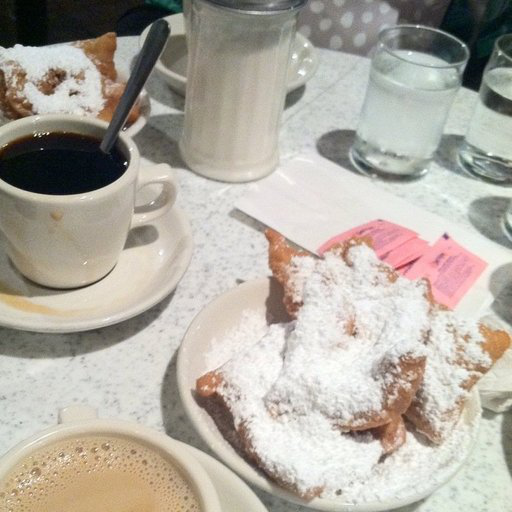

In [5]:
image = Image.open(
    urlopen("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png")
)
print(type(image))
print(image.size)
image

Currently it's a .png file of size 512x512 and the model expects a tensor of size 224x224. Although ViT can work on a different sizes the model was trained on this exact resolution, so for the best result let's resize the image.

In [6]:
image_transform = ImageTransform(resize_to=model.image_size)
x = image_transform(image)
print(x.shape, x.type())

torch.Size([1, 3, 224, 224]) torch.FloatTensor


## 3. Do the forward pass

The input is prepared. The only remaining step is to provide the input into the model. It will give us model's output - logits.

In [7]:
logits = model(x)
logits.shape

torch.Size([1, 1000])

There is 1 row with 1000 values. That's because only a single image was provided and logits contains model's output for each class (the model was trained on 1000 classes).

### 3.1. Decode logits

In order to see what classes are predicted we need to decode logits by applying softmax first and transform indices of highest probabilities into class names.

In [8]:
output_decoded = model.decode_logits(logits, top_k=5)

for image_num in output_decoded:
    print(f" Image {image_num + 1} ".center(40, "="))
    for record in output_decoded[image_num]:
        print(f"Class: {record['class']:10} | probability: {record['probability']:.4f}")

=============== Image 1 ================
Class: espresso   | probability: 0.9863
Class: eggnog     | probability: 0.0077
Class: coffee mug | probability: 0.0055
Class: cup        | probability: 0.0005
Class: bakery, bakeshop, bakehouse | probability: 0.0000


As we can see the model thinks that the image contains `espresso`. It has the highest probability. </br>
Also it thinks that there are sum cups, eggnogs, bakery ... in the image, though the probability of it is much much lower.